In [1]:
# cargar librerías

import matplotlib
from matplotlib import pyplot
import rasterio
from rasterio import mask
from rasterio.plot import show
import geopandas as gpd
import fiona

In [3]:
# rutas a imagen sin cortar y shapefiles con mallas regulares

image_path = "../../../../RSdata/MDE_GoogleEarth/img_prep/mde_z18_s_p.dat"
shp_m30_path = "../Datos/4_accidentes/m30u_acc_v.shp"

In [4]:
# cargar imagen

img = rasterio.open(image_path)

In [5]:
# cargar shapefile con geopandas

m_acc = gpd.read_file(shp_m30_path)

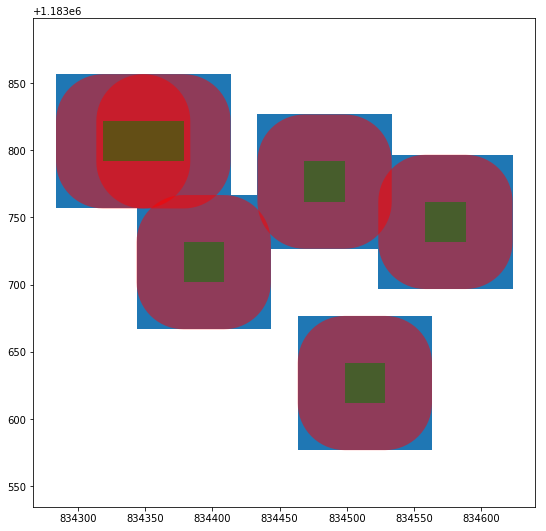

In [4]:
# test de visualización
# celda original: verde
# buffer de 35 metros: rojo
# envelope del buffer: azul

f, ax = pyplot.subplots(1, figsize=(9, 9))
pyplot.axis('equal')
m_acc.buffer(35).envelope.plot(ax=ax, alpha = 1, linewidth = 0.5)
m_acc.buffer(35).plot(ax=ax, alpha = 0.5, facecolor = "red")
m_acc.plot(ax=ax, facecolor = "green", alpha = 0.5)

In [6]:
# crea una copia del geodataframe para modificarlo in-situ con buffer + envelope

m_acc_b = m_acc
m_acc_b['geometry'] = m_acc_b.geometry.buffer(35).envelope

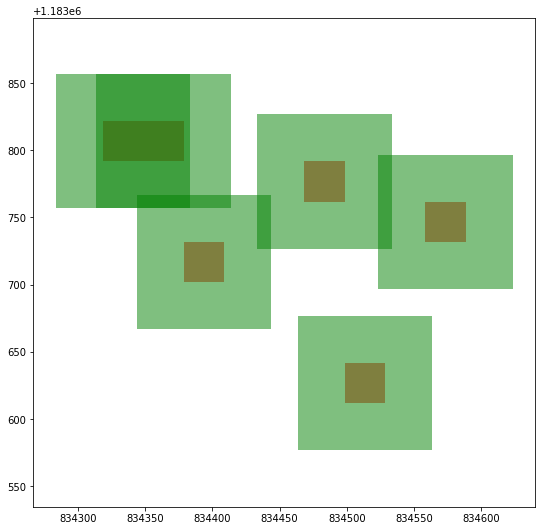

In [10]:
# visualización sobre malla sin buffer

m_acc = gpd.read_file(shp_m30_path)

f, ax = pyplot.subplots(1, figsize=(9, 9))
pyplot.axis('equal')
m_acc.plot(ax=ax, facecolor = "red", alpha = 0.5, linewidth = 0.5)
m_acc_b.plot(ax=ax, alpha = 0.5, facecolor = "green")

In [7]:
#escribir celdas con buffer cuadrado
out_shp = "../Datos/4_accidentes/m30u_acc_v_buf35c.shp"
m_acc_b.to_file(driver = 'ESRI Shapefile', filename= out_shp)

In [ ]:
# clip con celdas del shapefile out_shp

shp = fiona.open(out_shp)


for feat in shp:
    name = feat['properties']['ID']
    out_path = "../../1_img_tiles/tiles_m30/" + str(name) + ".tif"
    crop_poly = [feat['geometry']]
    out_image, out_transform = mask.mask(img, crop_poly, crop=True)
    out_meta = img.meta.copy()
    out_meta.update({"driver": "GTiff", \
                 "height": out_image.shape[1], \
                 "width": out_image.shape[2], \
                 "transform": out_transform})
    with rasterio.open(out_path, "w", **out_meta) as dest:
        dest.write(out_image)